# Quickstart

[ReAct Agent](https://docs.langchain.com/oss/python/langchain/agents#tool-use-in-the-react-loop) is an Agent that combines **Reasoning** with **Acting**. ReAct is a core pattern for building Agents and the component that best demonstrates autonomy in agent frameworks.

Its workflow follows a three-step loop:

1. Think
2. Act
3. Observe

This loop continues until the LLM determines that the task is completed or cannot proceed.

This means the Agent can automatically supplement unknown context information through tool calls. Then, based on the newly acquired information, it makes the next decision. For example, if you ask the Agent to query records in a database, it may not yet know what tables exist in the database or what fields are in those tables. But through several rounds of active querying and observation, even if your query is somewhat vague, it can likely infer which record you need from the table names and fields. This is the power of ReAct Agent.

This section covers:

- How to create a simple ReAct Agent
- How to create a ReAct Agent with tools
- How to create a ReAct Agent with tool permissions
- Structured output
- Streaming output


## 1. Environment Setup

### 1.1 Install Dependencies

You can download [this repository](https://github.com/luochang212/dive-into-langgraph) to your local machine, then run the following command to install the complete Python dependencies:

```bash
cd dive-into-langgraph
pip install -r requirements.txt
```

```{dropdown} Dependency List
  Here is the list of dependencies in `requirements.txt`:

  - `pydantic`
  - `python-dotenv`
  - `langchain[openai]`
  - `langchain-community`
  - `langchain-mcp-adapters`
  - `langchain-text-splitters`
  - `langgraph`
  - `langgraph-cli[inmem]`
  - `langgraph-supervisor`
  - `langgraph-checkpoint-sqlite`
  - `langgraph-checkpoint-redis`
  - `langmem`
  - `ipynbname`
  - `fastmcp`
  - `bs4`
  - `scikit-learn`
  - `supervisor`
  - `jieba`
  - `dashscope`
  - `tavily-python`
  - `ddgs`

```

Alternatively, you can directly install LangGraph and install missing dependencies as needed:

```bash
pip install langgraph langchain
```

### 1.2 Import Dependencies

Create a .env file using .env.example:

```bash
cp .env.example .env
```

> PS: This tutorial uses models from the Alibaba Bailian platform. You need to register an account on the [Alibaba Bailian Platform](https://bailian.console.aliyun.com/) and fill the obtained API key into the `DASHSCOPE_API_KEY` variable in the .env file.

In [1]:
import os

from dotenv import load_dotenv
from IPython.display import HTML, display, update_display
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model

# Load model configuration
# Please configure DASHSCOPE_API_KEY in .env file first
_ = load_dotenv()

### 1.3 Load LLM

Here are two methods to load the LLM, choose either one:

In [2]:
# Method 1: Load LLM using ChatOpenAI
llm = ChatOpenAI(
    model="qwen3-coder-plus",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
)

# Method 2: Load LLM using init_chat_model
llm = init_chat_model(
    model="qwen3-coder-plus",
    model_provider="openai",  # Qwen is compatible with OpenAI API
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
)

## 2. Simple Agent

First, create the simplest ReAct Agent.

In [3]:
# Create a simple Agent
agent = create_agent(
    model=llm,
    system_prompt="You are a helpful assistant",
)

# Run Agent
response = agent.invoke({'messages': 'hello'})

response['messages'][-1].content

'Hello! How can I assist you today?'

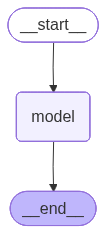

In [4]:
# Visualize Agent
agent

## 3. Agent with Tool Calling

Next, we create a ReAct Agent with tool calling, which can autonomously decide whether to call tools based on requirements.

In [5]:
# A tool function
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's sunny in {city}!"

# Create Agent with tool calling
tool_agent = create_agent(
    model=llm,
    tools=[get_weather],
    system_prompt="You are a helpful assistant",
)

# Run Agent
response = tool_agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)

response['messages'][-1].content

'The weather in San Francisco (SF) is currently sunny!'

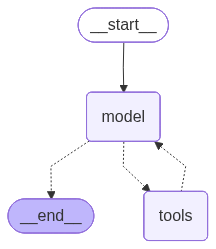

In [6]:
# Visualize Agent
tool_agent

## 4. Using `ToolRuntime` to Control Tool Permissions

Below we create a tool with runtime, where the runtime type is ToolRuntime. When we call the Agent, we pass this runtime to the tool. The tool then determines whether the current call has execution permission based on the information in the runtime.

In [7]:
from typing import Literal, Any
from pydantic import BaseModel
from langchain.tools import tool, ToolRuntime

class Context(BaseModel):
    authority: Literal["admin", "user"]

# Create tool with permission control, depends on ToolRuntime content for judgment
@tool
def math_add(runtime: ToolRuntime[Context, Any], a: int, b: int) -> int:
    """Add two numbers together."""
    authority = runtime.context.authority
    # Only admin users can access the addition tool
    if authority != "admin":
        raise PermissionError("User does not have permission to add numbers")
    return a + b

# Create Agent with tool calling
tool_agent = create_agent(
    model=llm,
    tools=[get_weather, math_add],
    system_prompt="You are a helpful assistant",
)

# Inject context when running Agent
response = tool_agent.invoke(
    {"messages": [{"role": "user", "content": "Please calculate 8234783 + 94123832 = ?"}]},
    config={"configurable": {"thread_id": "1"}},
    context=Context(authority="admin"),
)

In [8]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Please calculate 8234783 + 94123832 = ?
================================== Ai Message ==================================
Tool Calls:
  math_add (call_726f6b3a42134c0bb36f1bb7)
 Call ID: call_726f6b3a42134c0bb36f1bb7
  Args:
    a: 8234783
    b: 94123832
================================= Tool Message =================================
Name: math_add

102358615
================================== Ai Message ==================================

The sum of 8234783 and 94123832 is 102358615.


In [9]:
# Verify the calculation result is correct
8234783 + 94123832

102358615

## 5. Structured Output

To get [structured output](https://docs.langchain.com/oss/python/langchain/structured-output#response-format), you can set the `response_format` parameter in the `create_agent` function. In the following example, we define the output format using BaseModel and specify this format in `response_format`.

In [10]:
from pydantic import BaseModel, Field

class CalcInfo(BaseModel):
    """Calculation information."""
    output: int = Field(description="The calculation result")

In [11]:
# Create Agent with structured output
structured_agent = create_agent(
    model=llm,
    tools=[get_weather, math_add],
    system_prompt="You are a helpful assistant",
    response_format=CalcInfo,
)

response = structured_agent.invoke(
    {"messages": [{"role": "user", "content": "Please calculate 8234783 + 94123832 = ?"}]},
    config={"configurable": {"thread_id": "1"}},
    context=Context(authority="admin"),
)

In [12]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Please calculate 8234783 + 94123832 = ?
================================== Ai Message ==================================
Tool Calls:
  math_add (call_56cf16ee56aa4a6193cabf42)
 Call ID: call_56cf16ee56aa4a6193cabf42
  Args:
    a: 8234783
    b: 94123832
================================= Tool Message =================================
Name: math_add

102358615
================================== Ai Message ==================================
Tool Calls:
  CalcInfo (call_3281c9eabf8a4f31aca53ea0)
 Call ID: call_3281c9eabf8a4f31aca53ea0
  Args:
    output: 102358615
================================= Tool Message =================================
Name: CalcInfo

Returning structured response: output=102358615


In [13]:
response['structured_response']

CalcInfo(output=102358615)

## 6. Streaming Output

Below is a brief introduction. For more information, please refer to [streaming](https://docs.langchain.com/oss/python/langchain/streaming/overview).

### 6.1 updates Mode

`stream_mode="updates"`: Stream updates after each node completes

In [14]:
%autoawait on

agent = create_agent(
    model=llm,
    tools=[get_weather],
)

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
    stream_mode="updates",
):
    for step, data in chunk.items():
        print(f"step: {step}")
        print(f"content: {data['messages'][-1].content_blocks}")

step: model
content: [{'type': 'tool_call', 'name': 'get_weather', 'args': {'city': 'SF'}, 'id': 'call_f6ff6132964a46fe8b133077'}]
step: tools
content: [{'type': 'text', 'text': "It's sunny in SF!"}]
step: model
content: [{'type': 'text', 'text': 'The weather in San Francisco is sunny! 🌞'}]


### 6.2 messages Mode

`stream_mode="messages"`: Stream updates after each token is generated

In [15]:
async def agent_invoke():
    content, last_node = "", ""
    display_handle = display("", display_id=True)

    async for token, metadata in agent.astream(  
        {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
        stream_mode="messages",
    ):
        node = metadata['langgraph_node']
        if last_node and node != last_node:
            content += f"\n\n🔹 <b>node:</b> {node}\n📝 <b>content: </b>"
        if node == 'model' and token.content:
            content += token.content
        elif node == 'tools' and token.content:
            content += token.content

        last_node = node
        update_display(HTML(f"<pre>{content}</pre>"), display_id=display_handle.display_id)

print("Print output results of tool node and model node:")
await agent_invoke()

Print output results of tool node and model node:


### 6.3 values Mode

`stream_mode="values"`: Stream snapshots of the State, allowing you to view tool call information

In [16]:
async def agent_invoke():
    content, last_node = "", ""

    async for payload in agent.astream(  
        {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
        stream_mode="messages",
    ):
        state = payload[0]
        if hasattr(state, "tool_calls") and state.tool_calls:
            if state.tool_calls[0].get('name'):
                print("name:", state.tool_calls[0].get('name'))
            if state.tool_calls[0].get('args'):
                print("args:", state.tool_calls[0].get('args'))

print("Print tool call information:\n")
await agent_invoke()

Print tool call information:

name: get_weather
args: {'city': 'SF'}
